# Sankt Nikolaus Rally

In [1]:
import datetime as dt
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf

import available as avb
import utils as self_utils
from quantified_strategies import strategy_utils as utils

In [22]:
START = dt.date(2000, 1, 1)
END = dt.date.today()

XDAY = 4
ENTER_ON_N_XDAY_OF_DEC = 3

## Rules

1. Buy on the third Friday in December (when DAX futures expire)
2. Close position on the last trading day of the year.

In [23]:
TICKER = "ISF.LSE"
TICKER = "EWG.US"
TICKER = "FEZ.US"
TICKER = "CACX.LSE"
TICKER = "NXT.LSE"

In [24]:
results = self_utils.run(ticker=TICKER, full=True, start=START, end=END, entry_day=XDAY, nth_entry_day=ENTER_ON_N_XDAY_OF_DEC)
results

{}
remove api from here


,asset,ret,ret_shifted,active,strat_ret,cum_strat_ret,cum_hodl_ret,enter_flag,trade_number
Date,,,,,,,,,
2000-01-04,283.6595,NaN,-0.024391,False,-0.0,0.000000,-0.024391,False,0
2000-01-05,276.7409,-0.024391,0.005000,False,0.0,0.000000,-0.019512,False,0
2000-01-06,278.1246,0.005000,0.008292,False,0.0,0.000000,-0.011382,False,0
2000-01-07,280.4308,0.008292,-0.031250,False,-0.0,0.000000,-0.042276,False,0
2000-01-10,271.6674,-0.031250,-0.028862,False,-0.0,0.000000,-0.069919,False,0
...,...,...,...,...,...,...,...,...,...
2024-02-27,8362.0000,-0.007124,-0.000957,False,-0.0,0.476858,28.450803,False,24
2024-02-28,8354.0000,-0.000957,-0.004788,False,-0.0,0.476858,28.309789,False,24
2024-02-29,8314.0000,-0.004788,0.011547,False,0.0,0.476858,28.648223,False,24


In [39]:
utils.describe(returns=results["strat_ret"], pos=results["active"], daily=True, asset=TICKER)

Asset                        NXT.LSE
Start                     2000-01-04
End                       2024-03-04
Mean Return                 0.25409%
Total Return                  47.69%
Median Return               0.11822%
1st Quartile               -0.54557%
3rd Quartile                0.97525%
Std Dev Return              1.19147%
CAGR                      24.709 bps
Trade CAGR                    0.816%
Ann. CAGR                    86.245%
Activity Ratio                 2.59%
Number of Trades                  48
Average Hold Period        3.29 Days
Daily Sharpe Ratio            0.2133
Ann. Sharpe Ratio             3.3854
Adj. Ann. Sharpe Ratio        0.5446
Daily Sortino Ratio            0.397
Ann. Sortino Ratio            1.0139
Daily Calmar Ratio            7.0876
Hit Ratio                     56.96%
Profit Factor                  1.80x
MDD                           -6.73%
MDD Start                 2017-12-21
MDD Bottom                2020-12-18
MDD End                   2020-12-24
M

In [25]:
data = utils.get_data(ticker=TICKER, columns="Adj Close")
data = data.to_frame(name=TICKER)
data.tail(5)

{}
remove api from here


,NXT.LSE
Date,
2024-02-27,8362.0
2024-02-28,8354.0
2024-02-29,8314.0
2024-03-01,8410.0
2024-03-04,8184.0


In [26]:
data = data.loc[(data.index.date >= START) & (data.index.date <= END)]
data.head(5)

,NXT.LSE
Date,
2000-01-04,283.6595
2000-01-05,276.7409
2000-01-06,278.1246
2000-01-07,280.4308
2000-01-10,271.6674


### Get entrance px

In [27]:
december_data = data.loc[data.index.month == 12].copy()
xday_data = december_data.loc[december_data.index.weekday == XDAY].copy()
xday_data["year"] = xday_data.index.year

first_n_xdays_in_dec = xday_data.groupby("year").head(ENTER_ON_N_XDAY_OF_DEC)
nth_xday_in_dec = first_n_xdays_in_dec.groupby("year").tail(1)

entrance_px = nth_xday_in_dec.set_index("year")[TICKER].to_frame(name="enter")
entrance_px.head(5)

,enter
year,
2000,358.2354
2001,433.4286
2002,368.2626
2003,571.4290
2004,873.0977


### Get exit px

In [28]:
last_trading_day_of_year = data.resample("YE").last()
exit_px = last_trading_day_of_year.rename(columns={TICKER: "exit"})
exit_px.index = exit_px.index.year
exit_px.index.name = "year"
exit_px.head(5)

,exit
year,
2000,383.4834
2001,437.5845
2002,370.9065
2003,583.3771
2004,878.9574


### Join Data

In [29]:
df = pd.concat([entrance_px, exit_px], axis=1)
df.index = df.index.map(lambda year: pd.Timestamp(dt.date(year, 12, 31)))
df.head(5)

,enter,exit
year,,
2000-12-31,358.2354,383.4834
2001-12-31,433.4286,437.5845
2002-12-31,368.2626,370.9065
2003-12-31,571.4290,583.3771
2004-12-31,873.0977,878.9574


In [30]:
df["ret"] = (df["exit"] / df["enter"] - 1)
df["cumret"] = utils.get_cumulative_return(df["ret"], total=False)

In [31]:
df

,enter,exit,ret,cumret
year,,,,
2000-12-31,358.2354,383.4834,0.070479,0.070479
2001-12-31,433.4286,437.5845,0.009588,0.080743
2002-12-31,368.2626,370.9065,0.007179,0.088502
2003-12-31,571.4290,583.3771,0.020909,0.111262
2004-12-31,873.0977,878.9574,0.006711,0.118720
2005-12-31,852.5365,841.5714,-0.012862,0.104331
2006-12-31,1007.1131,1012.7394,0.005587,0.110501
2007-12-31,923.8194,937.0910,0.014366,0.126454
2008-12-31,672.8328,655.2543,-0.026126,0.097024


In [32]:
df1 = self_utils.run(ticker=TICKER, start=START, end=END, full=True)

{}
remove api from here


In [33]:
df1

,asset,ret,ret_shifted,active,strat_ret,cum_strat_ret,cum_hodl_ret,enter_flag,trade_number
Date,,,,,,,,,
2000-01-04,283.6595,NaN,-0.024391,False,-0.0,0.000000,-0.024391,False,0
2000-01-05,276.7409,-0.024391,0.005000,False,0.0,0.000000,-0.019512,False,0
2000-01-06,278.1246,0.005000,0.008292,False,0.0,0.000000,-0.011382,False,0
2000-01-07,280.4308,0.008292,-0.031250,False,-0.0,0.000000,-0.042276,False,0
2000-01-10,271.6674,-0.031250,-0.028862,False,-0.0,0.000000,-0.069919,False,0
...,...,...,...,...,...,...,...,...,...
2024-02-27,8362.0000,-0.007124,-0.000957,False,-0.0,0.476858,28.450803,False,24
2024-02-28,8354.0000,-0.000957,-0.004788,False,-0.0,0.476858,28.309789,False,24
2024-02-29,8314.0000,-0.004788,0.011547,False,0.0,0.476858,28.648223,False,24


## Plot Strategy Results

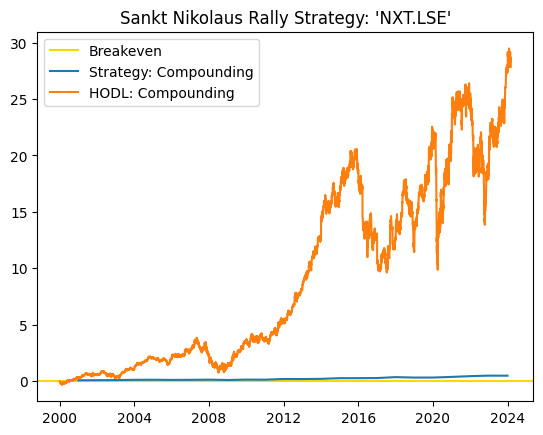

In [34]:
fig, ax = plt.subplots()

ax.axhline(y=0, label="Breakeven", color="gold")

ax.plot(df["cumret"], label="Strategy: Compounding")
# ax.plot(df["ret"].cumsum(), label="Strategy: Cumulative")
ax.plot(utils.get_cumulative_return(returns=data[TICKER].pct_change(), total=False), label="HODL: Compounding")
# ax.plot(data[TICKER].pct_change().cumsum(), label="HODL: Cumulative")

plt.title(f"Sankt Nikolaus Rally Strategy: {TICKER!r}")
plt.legend(loc="best")
plt.show()

## Describe Strategy Results

In [37]:
utils.describe(returns=df["ret"], daily=False, asset=TICKER)

Asset                         NXT.LSE
Start                      2000-12-31
End                        2024-12-31
Mean Return                  1.67256%
Total Return                   47.69%
Median Return                0.83839%
1st Quartile                -0.14785%
3rd Quartile                 3.82554%
Std Dev Return               2.71949%
CAGR                      157.189 bps
Trade CAGR                        N/A
Ann. CAGR                  4,992.551%
Activity Ratio                100.00%
Number of Trades                  0.0
Average Hold Period        25.00 Days
Daily Sharpe Ratio              0.615
Ann. Sharpe Ratio              9.7633
Adj. Ann. Sharpe Ratio         9.7633
Daily Sortino Ratio            1.4328
Ann. Sortino Ratio            22.7451
Daily Calmar Ratio            16.4696
Hit Ratio                      68.00%
Profit Factor                   6.00x
MDD                            -2.90%
MDD Start                  2017-12-31
MDD Bottom                 2018-12-31
MDD End     

In [36]:
utils.describe(returns=data[TICKER].pct_change(), daily=True, asset=TICKER)

Asset                           NXT.LSE
Start                        2000-01-04
End                          2024-03-04
Mean Return                    0.07429%
Total Return                  2,785.15%
Median Return                  0.05904%
1st Quartile                  -0.81181%
3rd Quartile                   0.96091%
Std Dev Return                 1.96029%
CAGR                          5.508 bps
Trade CAGR                          N/A
Ann. CAGR                       14.885%
Activity Ratio                  100.00%
Number of Trades                    0.0
Average Hold Period       6,106.00 Days
Daily Sharpe Ratio               0.0379
Ann. Sharpe Ratio                0.6016
Adj. Ann. Sharpe Ratio           0.6016
Daily Sortino Ratio              0.0522
Ann. Sortino Ratio               0.8291
Daily Calmar Ratio              43.7787
Hit Ratio                        50.98%
Profit Factor                     1.12x
MDD                             -63.62%
MDD Start                    2007-05-09
